In [1]:
#In the name of God

student_id = 401210923
student_name = "Navid Farahani"

print("your student id:", student_id)
print("your name:", student_name)
import numpy as np
import torch
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn
import os

from torch.utils.data import random_split
import matplotlib.pyplot as plt
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
import random
from torchvision.models import resnet50
import torch.nn.functional as F
print("For better understanding CNNs, I watched this video from Youtube: https://www.youtube.com/watch?v=d9QHNkD_Pos")

print("Also for beter understanding Triplet Loss, I watched this video from Youtube: https://www.youtube.com/watch?v=d2XB5-tuCWU")

your student id: 401210923
your name: Navid Farahani
For better understanding CNNs, I watched this video from Youtube: https://www.youtube.com/watch?v=d9QHNkD_Pos
Also for beter understanding Triplet Loss, I watched this video from Youtube: https://www.youtube.com/watch?v=d2XB5-tuCWU


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [3]:
# Dataset

# Define transforms for data
# For better result, we did Data Augmentation due to increase the accuracy.
# such as Cropping and horizontally flipping.
# Also we consider normalizing with mean = 0.5 and std=0.5 for all channels.
train_transforms = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transforms)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=val_transforms)

100%|██████████| 170498071/170498071 [00:03<00:00, 43280721.61it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
# We want to use classes where have 0 or 1 labels so we have:

dataset2_indexes_lower_volume=[]
for i in range(0,50000):
    if (train_dataset[i][1]==0 or train_dataset[i][1]==1):
        dataset2_indexes_lower_volume.append(i)

# We use just num_images images(for example 3000 images) for faster convergence.
# Note that we will use these images again for part 2 and 3 of this question for Fully Connected Layer training.

num_images=3000
np.random.shuffle(dataset2_indexes_lower_volume)
dataset2_indexes_lower_volume=dataset2_indexes_lower_volume[0:num_images]

dataset2 = torch.utils.data.Subset(train_dataset, dataset2_indexes_lower_volume)

# We consider 80% data for train and 20% for validation
num_train=int(num_images*0.8)
num_validation=int(num_images*0.2)
train_dataset,validation_dataset=random_split(dataset2,[num_train,num_validation])


batch_size=128
train_dl=DataLoader(train_dataset,batch_size,shuffle=True,num_workers=4,pin_memory=True)
val_dl=DataLoader(validation_dataset,batch_size*2,num_workers=4,pin_memory=True)

dataset2_test_indexes_lower_volume=[]

for i in range(0,10000):
    if (test_dataset[i][1]==0 or test_dataset[i][1]==1):
        dataset2_test_indexes_lower_volume.append(i)



num_images_test=300
np.random.shuffle(dataset2_test_indexes_lower_volume)
dataset2_indexes_lower_volume_test=dataset2_test_indexes_lower_volume[0:num_images_test]

dataset2 = torch.utils.data.Subset(test_dataset, dataset2_indexes_lower_volume_test)

test_dl=DataLoader(dataset2,batch_size*2,num_workers=4,pin_memory=True)




def to_device(data, device):
    # for every batch, we pass the data to the current device.
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)



class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl=dl
        self.device=device

    def __iter__(self):
        #For every batch, we pass it to the current device.
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

# Selecting the current device
if torch.cuda.is_available():
      device=torch.device('cuda')
else:
      device=torch.device('cpu')

# We move train, validation and test loaders to current device for every batch by using this code
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 168MB/s]


Epoch 1/20, Loss: 0.5519, Accuracy: 0.7400
Epoch 2/20, Loss: 0.4212, Accuracy: 0.8000
Epoch 3/20, Loss: 0.4557, Accuracy: 0.8100
Epoch 4/20, Loss: 0.5037, Accuracy: 0.8233
Epoch 5/20, Loss: 0.4021, Accuracy: 0.8250
Epoch 6/20, Loss: 0.3466, Accuracy: 0.8350
Epoch 7/20, Loss: 0.3352, Accuracy: 0.8150
Epoch 8/20, Loss: 0.2849, Accuracy: 0.8350
Epoch 9/20, Loss: 0.3552, Accuracy: 0.8300
Epoch 10/20, Loss: 0.4275, Accuracy: 0.8450
Epoch 11/20, Loss: 0.2781, Accuracy: 0.8500
Epoch 12/20, Loss: 0.3998, Accuracy: 0.8233
Epoch 13/20, Loss: 0.3617, Accuracy: 0.8400
Epoch 14/20, Loss: 0.4481, Accuracy: 0.8217
Epoch 15/20, Loss: 0.3605, Accuracy: 0.8333
Epoch 16/20, Loss: 0.3768, Accuracy: 0.8300
Epoch 17/20, Loss: 0.3355, Accuracy: 0.8333
Epoch 18/20, Loss: 0.2759, Accuracy: 0.8067
Epoch 19/20, Loss: 0.2845, Accuracy: 0.8267
Epoch 20/20, Loss: 0.3944, Accuracy: 0.8383


Text(0, 0.5, 'Loss')

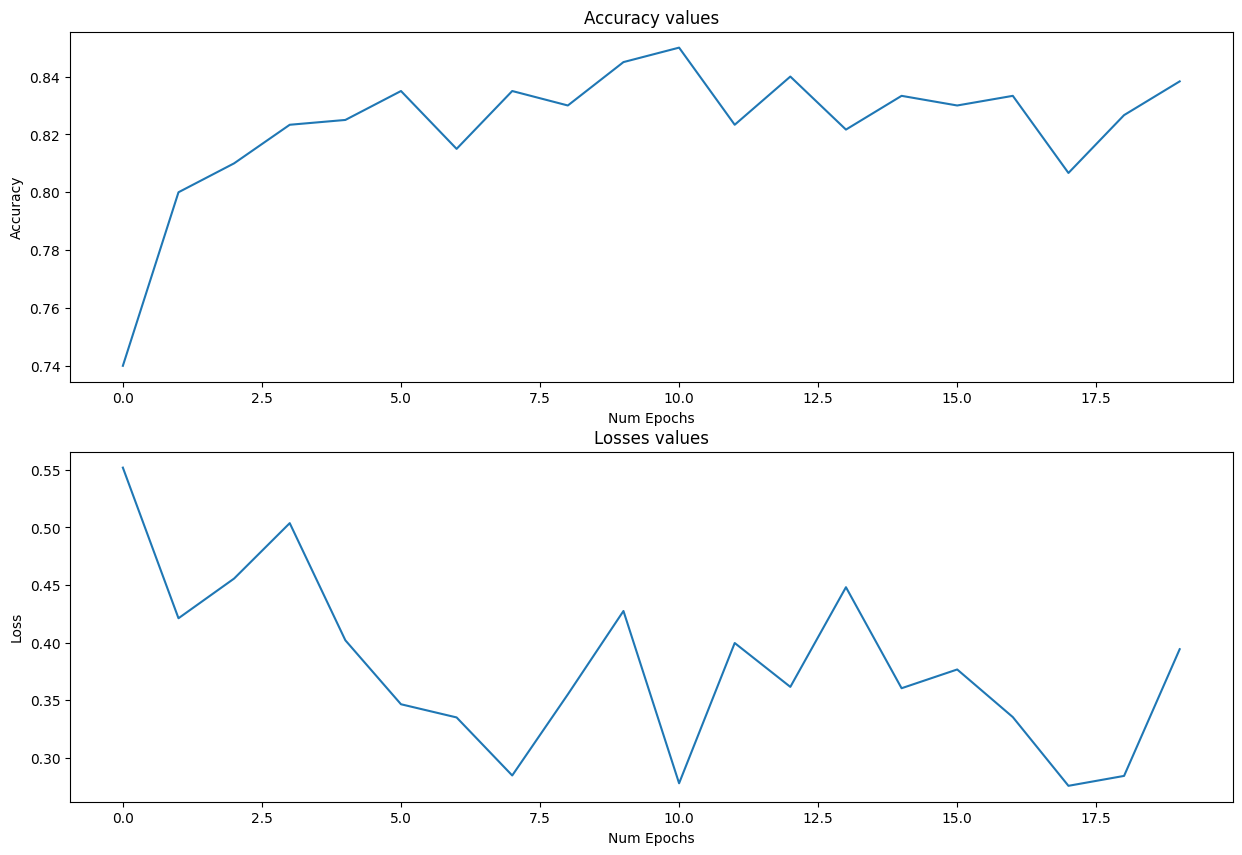

In [5]:

# Load RESNET34 model and modify the last layer for CIFAR10 classification

model=models.resnet34(pretrained=True)# We use pretrained network of RESNET34
num_features=model.fc.in_features
model.fc=nn.Linear(num_features,2)# We have 2 classes (Airplane and automobile, so we have 2 neurons for the last layer )

# Freeze all layers except the Fully Connected Layer. We just want to update Fully Connected Layer, so we have:
for param in model.parameters():
    param.requires_grad=False
for param in model.fc.parameters():
    param.requires_grad=True

model.to(device)
# Define loss function and optimizer
optimizer=optim.Adam(model.fc.parameters(),lr=0.001)# Using ADAM as optimizer.

# Train the model
num_epochs=20
accuracies=np.zeros(num_epochs)
losses=np.zeros(num_epochs)

# Please note that we calculate loss and accuracy for val_dl which is come from train_dataset which the trainable ability was True for that


for epoch in range(num_epochs):
    # Training loop
    for images,labels in train_dl:
        images=images.to(device)
        labels=labels.to(device)
        optimizer.zero_grad()# we force the gradient to zero, because for every batch the gradient must be 0.
        outputs=model(images)# we pass the images from our model to determine its one-hot label
        loss=nn.CrossEntropyLoss()(outputs,labels)# Using CrossEntropy loss for loss function
        loss.backward()# We do backward for updating weights.
        losses[epoch]=loss
        optimizer.step()# we pass one iteration for the optimizer ADAM

    # Validation loop
    with torch.no_grad():
        all_labels=0
        acc=0
        for images,labels in val_dl:# or train_val
            images=images.to(device)
            labels=labels.to(device)
            outputs=model(images)
            _,predicted_labels=torch.max(outputs.data,1)
            all_labels=all_labels+labels.size(0)#we count all labels for validation dataset.
            acc=acc+torch.sum((predicted_labels==labels))#Accuracy is the hard comparison between labels and predicted labels.
        accuracies[epoch]=acc/all_labels

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {losses[epoch].item():.4f}, Accuracy: { accuracies[epoch]:.4f}")


plt.figure(figsize=(15,10))

plt.subplot(2,1,1)
plt.plot(accuracies)
plt.title("Accuracy values")
plt.xlabel("Num Epochs")
plt.ylabel("Accuracy")

plt.subplot(2,1,2)
plt.plot(losses)
plt.title("Losses values")
plt.xlabel("Num Epochs")
plt.ylabel("Loss")



In [6]:
all_labels=0
acc=0
with torch.no_grad():
        all_labels=0
        acc=0
        for images,labels in test_dl:
            images=images.to(device)
            labels=labels.to(device)
            outputs=model(images)
            _,predicted_labels=torch.max(outputs.data,1)
            all_labels=all_labels+labels.size(0)#we consider all labels for validation dataset.
            acc=acc+torch.sum((predicted_labels==labels))#Accuracy is the hard comparison between labels and predicted labels.

Accuracy_Method1=acc/all_labels
print("Accuracy for Test data is: "+str(100*np.array(Accuracy_Method1.to('cpu')))+"%")

Accuracy for Test data is: 81.00000023841858%


**Triplet Loss**

In [7]:
# Class for Dataset

class DatasetForTripletLoss(Dataset):
    def __init__(self,dataset):

        self.labels=[]
        self.images=[]

        for image,label in dataset:
            self.images.append(image)
            self.labels.append(label)

    def __getitem__(self,item):
        # Here we will have 3 images: anchor_image, positive_image and negative_image.
        # we know that labels of the positive and achor must be the same and labels of the negative and anchor must be different
        # Also, the images must not be identical
        anchor_image = self.images[item]
        anchor_label = self.labels[item]



        positive_labels=[]

        # images must not be identical, so we write j!=item.
        for j in range(len(self.labels)):
          if (self.labels[j]==anchor_label and j!=item):
            positive_labels.append(self.images[j])

        choice_for_positive=np.random.randint(0,len(positive_labels))
        A_positive_image =positive_labels[choice_for_positive]


        negative_labels=[]
        for j in range(len(self.labels)):
          if (self.labels[j]!=anchor_label):
            negative_labels.append(self.images[j])

        choice_for_negative=np.random.randint(0,len(negative_labels))
        A_negative_image =negative_labels[choice_for_negative]


        return anchor_image, A_positive_image, A_negative_image, anchor_label

    def __len__(self):
        return len(self.images)


# Sending to Dataloader and setting the device

dataset2_tripleLoss=DatasetForTripletLoss(dataset2)
dataloader2_tripleLoss=DataLoader(dataset2_tripleLoss,batch_size=batch_size,shuffle=True)
dataloader2_tripleLoss=DeviceDataLoader(dataloader2_tripleLoss,device)

# TripletLoss Class for Feature Layers

class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin


    def forward(self,anchor,positive,negative):


        # For triplet loss, we want to calculate the distance between anchor( considered image) and positive image(an image with the similar label)
        # and also calculate the distance between anchor and negative image(an image with a different label).
        # For distance, we consider norm2^2. Also, We want the first distance be lower than the second distance, so we have:
        # But, we consider a margin between these two distance which is a positive value.
        # For example, if distance_positive is 0.3 and distance_negative is 0.33, it is not good, so we consider self.marging
        # to make a longer interval between two distances(similar to margin in SVM)

        distance_positive=(anchor -positive).pow(2).sum(1)
        distance_negative=(anchor -negative).pow(2).sum(1)
        triplet_losses=torch.relu(distance_positive - distance_negative + self.margin)
        triplet_losses_mean=triplet_losses.mean()


        # If distance_positive-distance_negative+self.margin is lower than 0, this is OK, and we have no losses.
        # But if it is more than 0, we consider loss.Thus, we used ReLU to implement this loss function!

        # Now for all losses, we consider the average of them for the final loss.

        return triplet_losses_mean


# Defining the model

model=models.resnet34(pretrained=True)
triplet_loss_model=torch.nn.Sequential(*(list(model.children())[:-1]))# We pick all the layers except Fully Connected Layer
triplet_loss_model=to_device(triplet_loss_model, device)

In [8]:
# Training the Feature Layers using TripletLoss

losses=np.zeros(num_epochs)
criterion=TripletLoss()
opt_func=optim.Adam(triplet_loss_model.parameters(),lr=0.001)
for epoch in range(num_epochs):

  for anchor_images,positive_images,negative_images,labels in dataloader2_tripleLoss:
    # in triplet_loss_model, the output is the deepest layer.
    # so we can achieve to deepest layer for all of the anchor, positive, and negative images for every batch.
    out_anchor = triplet_loss_model(anchor_images)
    out_positive = triplet_loss_model(positive_images)
    out_negative = triplet_loss_model(negative_images)

    anchor=torch.squeeze(out_anchor)
    positive=torch.squeeze(out_positive)
    negative=torch.squeeze(out_negative)
    loss = criterion.forward(anchor,positive,negative)
    loss.backward()
    opt_func.step()
    opt_func.zero_grad()
  losses[epoch]=loss.item()
  print('Epoch:',epoch,'train loss:',loss.item())


Epoch: 0 train loss: 47.4754524230957
Epoch: 1 train loss: 51.4439811706543
Epoch: 2 train loss: 17.982105255126953
Epoch: 3 train loss: 9.543905258178711
Epoch: 4 train loss: 6.97613525390625
Epoch: 5 train loss: 4.794421195983887
Epoch: 6 train loss: 8.977002143859863
Epoch: 7 train loss: 4.933682441711426
Epoch: 8 train loss: 9.217460632324219
Epoch: 9 train loss: 3.1846611499786377
Epoch: 10 train loss: 3.168360710144043
Epoch: 11 train loss: 6.5829010009765625
Epoch: 12 train loss: 6.544470310211182
Epoch: 13 train loss: 9.127034187316895
Epoch: 14 train loss: 4.281562805175781
Epoch: 15 train loss: 3.4605634212493896
Epoch: 16 train loss: 5.712551116943359
Epoch: 17 train loss: 2.377549409866333
Epoch: 18 train loss: 10.409193992614746
Epoch: 19 train loss: 4.922650337219238


In [9]:
class TripletLossNetwork(nn.Module):
    def __init__(self, triplet_loss_model):
        super(TripletLossNetwork, self).__init__()
        self.features=nn.Sequential(*(list(triplet_loss_model.children())[:-1]))# we consider all the network except the Fully Connected Layer
        self.avg_pool=nn.AdaptiveAvgPool2d((1, 1))# also we add an average pooling layer.
        self.fc=nn.Linear(512, 2, bias=True)# we added a linear layer 512 to 2, because the deepest layer has 512 features and we need 2 classes.

    def forward(self, x):
        # constructing the new network with separated Fully Connected Layers and Feature Layers, so after that we can set their required grads False and True
        x=self.features(x)
        x=self.avg_pool(x)
        x=torch.flatten(x, 1)
        x=self.fc(x)
        return x

Combined_model = TripletLossNetwork(triplet_loss_model)# New model for training the Fully Connected Layer

# Now we just want to train Fully Connected Layer, so we have:

for param in Combined_model.parameters():
    param.requires_grad=False
for param in Combined_model.fc.parameters():
    param.requires_grad=True
#Combined_model=to_device(Combined_model,device)
Combined_model.to(device)

TripletLossNetwork(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

Epoch 1/20, Loss: 0.6687, Accuracy: 0.7683
Epoch 2/20, Loss: 0.6054, Accuracy: 0.7833
Epoch 3/20, Loss: 0.5412, Accuracy: 0.8100
Epoch 4/20, Loss: 0.5215, Accuracy: 0.7917
Epoch 5/20, Loss: 0.4873, Accuracy: 0.7700
Epoch 6/20, Loss: 0.4761, Accuracy: 0.7850
Epoch 7/20, Loss: 0.4480, Accuracy: 0.8033
Epoch 8/20, Loss: 0.4845, Accuracy: 0.7900
Epoch 9/20, Loss: 0.4430, Accuracy: 0.8200
Epoch 10/20, Loss: 0.3922, Accuracy: 0.7833
Epoch 11/20, Loss: 0.4013, Accuracy: 0.8000
Epoch 12/20, Loss: 0.4413, Accuracy: 0.7950
Epoch 13/20, Loss: 0.4249, Accuracy: 0.8333
Epoch 14/20, Loss: 0.5037, Accuracy: 0.8083
Epoch 15/20, Loss: 0.4795, Accuracy: 0.8017
Epoch 16/20, Loss: 0.4837, Accuracy: 0.8200
Epoch 17/20, Loss: 0.4302, Accuracy: 0.7967
Epoch 18/20, Loss: 0.4739, Accuracy: 0.7717
Epoch 19/20, Loss: 0.4869, Accuracy: 0.8233
Epoch 20/20, Loss: 0.4563, Accuracy: 0.8233


Text(0, 0.5, 'Loss')

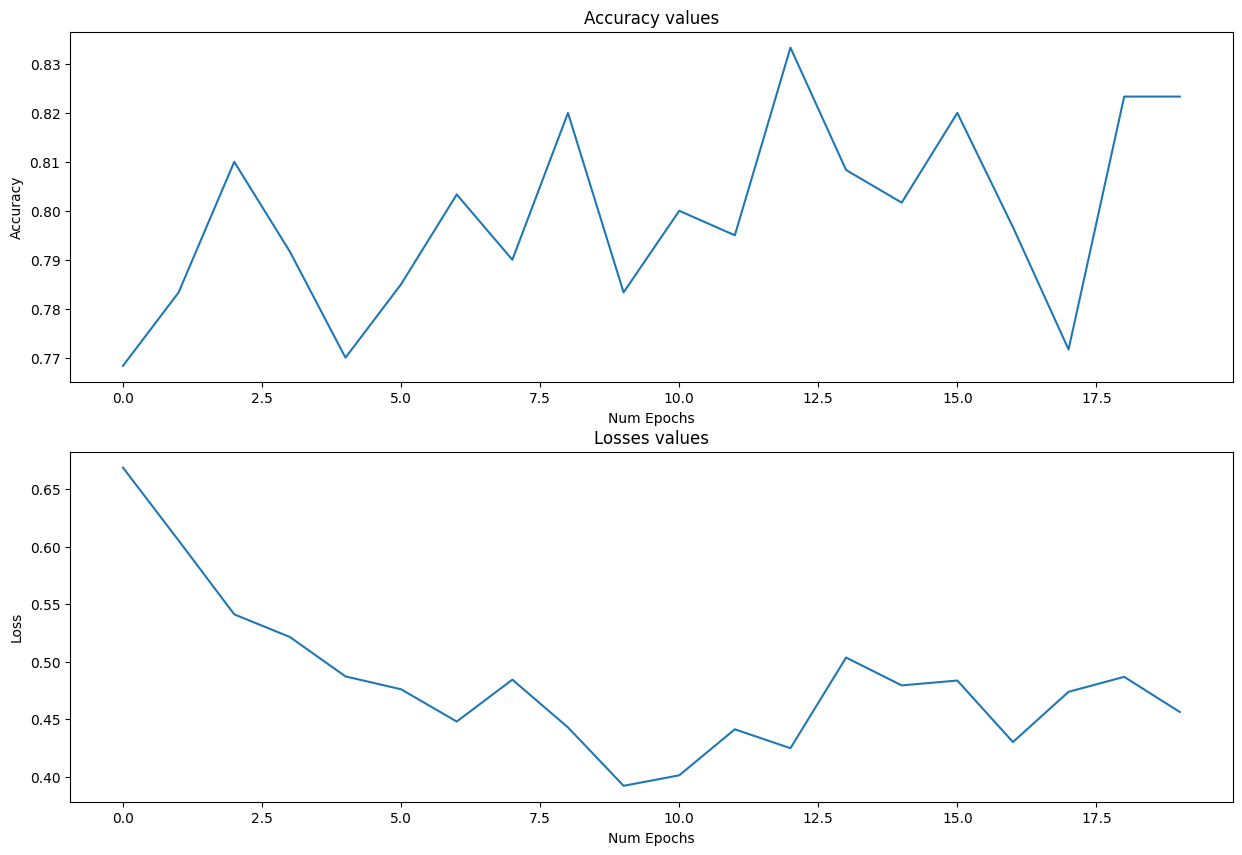

In [10]:
# Please note that we calculate loss and accuracy for val_dl which is come from train_dataset which the trainable ability was True for that

# This part is identical to the previous method.
accuracies=np.zeros(num_epochs)
losses=np.zeros(num_epochs)

opt_func = optim.Adam(Combined_model.fc.parameters(),lr=0.001)
criterion=nn.CrossEntropyLoss()
for epoch in range(num_epochs):
    # Training loop
    for images,labels in train_dl:
        images=images.to(device)
        labels=labels.to(device)
        opt_func.zero_grad()# we force the gradient to zero, because for every batch the gradient must be 0.
        outputs=Combined_model(images)# we pass the images from our model to determine its one-hot label
        loss=criterion(outputs,labels)# Using CrossEntropy loss for loss function
        loss.backward()# We do backward for updating weights.
        losses[epoch]=loss
        opt_func.step()# we pass one iteration for the optimizer ADAM

    # Validation loop
    with torch.no_grad():
        all_labels=0
        acc=0
        for images,labels in val_dl:# or train_val
            images=images.to(device)
            labels=labels.to(device)
            outputs=Combined_model(images)
            _,predicted_labels=torch.max(outputs.data,1)
            all_labels=all_labels+labels.size(0)#we count all labels for validation dataset.
            acc=acc+torch.sum((predicted_labels==labels))#Accuracy is the hard comparison between labels and predicted labels.
        accuracies[epoch]=acc/all_labels

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {losses[epoch].item():.4f}, Accuracy: { accuracies[epoch]:.4f}")

plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
plt.plot(accuracies)
plt.title("Accuracy values")
plt.xlabel("Num Epochs")
plt.ylabel("Accuracy")

plt.subplot(2,1,2)
plt.plot(losses)
plt.title("Losses values")
plt.xlabel("Num Epochs")
plt.ylabel("Loss")

In [11]:
all_labels=0
acc=0
with torch.no_grad():
        all_labels=0
        acc=0
        for images,labels in test_dl:
            images=images.to(device)
            labels=labels.to(device)
            outputs=Combined_model(images)
            _,predicted_labels=torch.max(outputs.data,1)
            all_labels=all_labels+labels.size(0)#we consider all labels for validation dataset.
            acc=acc+torch.sum((predicted_labels==labels))#Accuracy is the hard comparison between labels and predicted labels.

Accuracy_Method2=acc/all_labels
print("Accuracy for Test data is: "+str(100*np.array(Accuracy_Method2.to('cpu')))+"%")



Accuracy for Test data is: 91.00000262260437%


Epoch 1/20, Loss: 0.9433, Accuracy: 0.8483
Epoch 2/20, Loss: 1.3347, Accuracy: 0.9100
Epoch 3/20, Loss: 0.5842, Accuracy: 0.9317
Epoch 4/20, Loss: 0.5378, Accuracy: 0.9233
Epoch 5/20, Loss: 0.4835, Accuracy: 0.9383
Epoch 6/20, Loss: 0.4591, Accuracy: 0.9567
Epoch 7/20, Loss: 0.4882, Accuracy: 0.9267
Epoch 8/20, Loss: 0.4261, Accuracy: 0.9567
Epoch 9/20, Loss: 0.2649, Accuracy: 0.9450
Epoch 10/20, Loss: 0.5759, Accuracy: 0.9567
Epoch 11/20, Loss: 0.5461, Accuracy: 0.9417
Epoch 12/20, Loss: 0.3950, Accuracy: 0.9617
Epoch 13/20, Loss: 0.7470, Accuracy: 0.9450
Epoch 14/20, Loss: 0.2219, Accuracy: 0.9683
Epoch 15/20, Loss: 0.1270, Accuracy: 0.9583
Epoch 16/20, Loss: 0.2325, Accuracy: 0.9633
Epoch 17/20, Loss: 0.2514, Accuracy: 0.9500
Epoch 18/20, Loss: 0.2588, Accuracy: 0.9550
Epoch 19/20, Loss: 0.2062, Accuracy: 0.9517
Epoch 20/20, Loss: 0.2759, Accuracy: 0.9617


Text(0, 0.5, 'Loss')

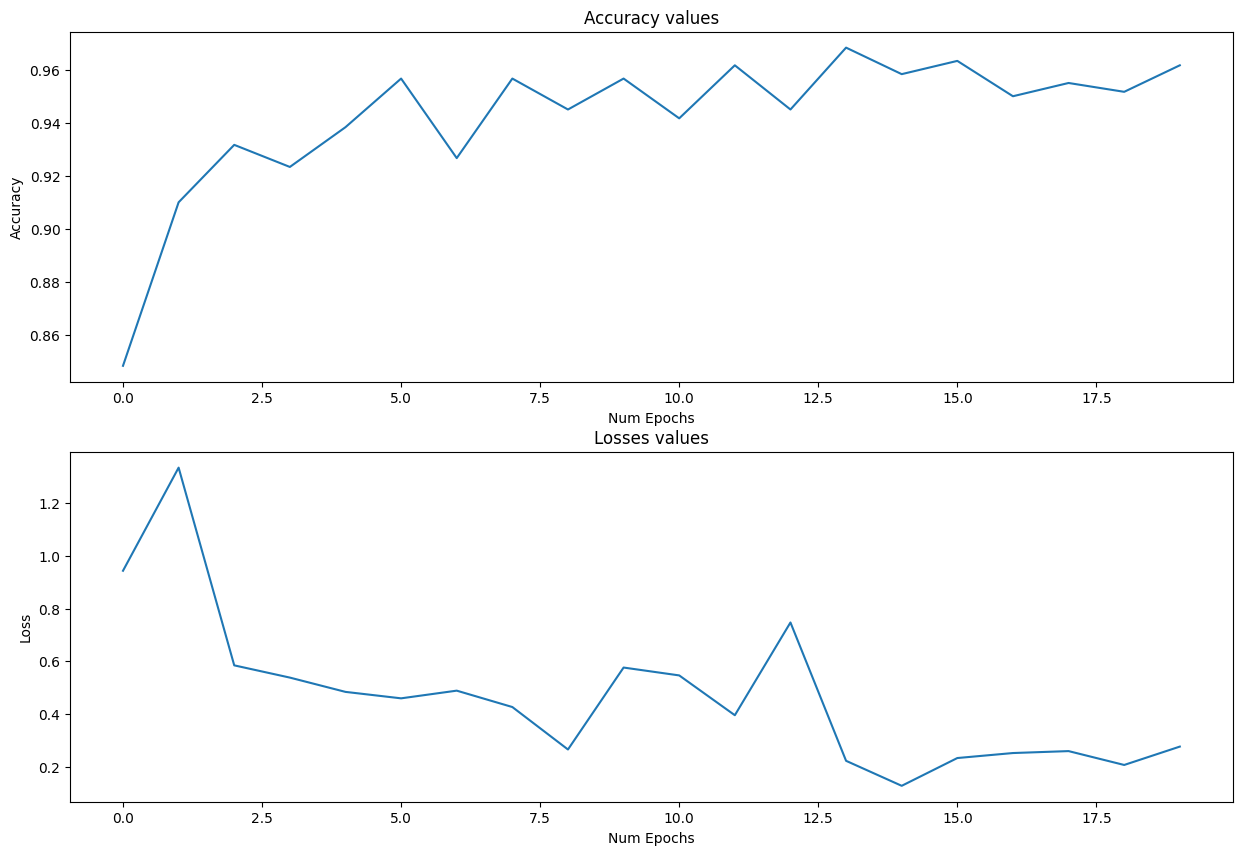

In [12]:
################### TRIPLET LOSS & Cross Entropy Loss for All the Network

model=models.resnet34(pretrained=True)
num_last_layer_features=model.fc.in_features
model.fc=nn.Linear(num_last_layer_features,2)

# Defining two loss functions, we will add them together.
criterion1=TripletLoss()
criterion2=nn.CrossEntropyLoss()
model.to(device)

criterion1.to(device)
criterion2.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

accuracies=np.zeros(num_epochs)
losses=np.zeros(num_epochs)
for epoch in range(num_epochs):
    # Training loop
    for images, labels in train_dl:
        images2=images.to(device)
        outputs=model(images2)

        anchor_images=[]
        positive_images=[]
        negative_images=[]
        for i in range(images.size(0)):
            anchor_images.append(images[i])#anchor_images are the considered images.
            positive_label = labels[i]# positive_label is the label for anchor_images,
            # But we need to consider positive images and by the help of this whilte True, we enter this loop, until find
            # a positive image.
            while True:
                positive_index = torch.randint(0, images.size(0), (1,))# catch a random index for examining it that if it can be positive label or not.
                if labels[positive_index] == positive_label:
                    break
            positive_images.append(images[positive_index])
            # Similarly, we find a negative images using this while True,
            while True:
                negative_index = torch.randint(0, images.size(0), (1,))# catch a random index for examining it that if it can be negative label or not.
                if labels[negative_index] != positive_label:
                    break
            negative_images.append(images[negative_index])

        # Now we have some positive and negative images and anchor images for two class classification.

        # We feed the images to the model and this process is identical to Part 2 of this question

        anchor_images = torch.stack(anchor_images).to(device)
        positive_images = torch.stack(positive_images).to(device)
        negative_images = torch.stack(negative_images).to(device)


        out_of_model=model(anchor_images)
        out_for_positive=model(np.squeeze(positive_images))
        out_for_negative=model(np.squeeze(negative_images))
        # Calculating the triplet loss
        loss1 = criterion1(out_of_model, out_for_positive, out_for_negative)
        labels=labels.to(device)


        loss2 = criterion2(out_of_model,labels)

        # We just need to add these two losses and backward method can calculate and update the weights automatically!
        # (Because in the same procedute, for Multiple Class Classification we can add some CrossEntropyLosses by using  "+"
        # In according to Slides of Dr.Fatemizadeh  )
        loss=loss1+loss2


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses[epoch]=loss
    # Validation loop
    with torch.no_grad():
        acc=0
        all_labels=0
        for images,labels in val_dl:
            images=images.to(device)
            labels=labels.to(device)
            out_of_model=model(images)
            outputs=nn.functional.softmax(out_of_model, dim=1)
            _, predicted=torch.max(outputs.data, 1)
            all_labels=all_labels+labels.size(0)
            acc=acc+(predicted== labels).sum().item()
        accuracy = acc / all_labels
        accuracies[epoch]=accuracy
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}")


plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
plt.plot(accuracies)
plt.title("Accuracy values")
plt.xlabel("Num Epochs")
plt.ylabel("Accuracy")

plt.subplot(2,1,2)
plt.plot(losses)
plt.title("Losses values")
plt.xlabel("Num Epochs")
plt.ylabel("Loss")

In [13]:
all_labels=0
acc=0
with torch.no_grad():
        all_labels=0
        acc=0
        for images,labels in test_dl:
            images=images.to(device)
            labels=labels.to(device)
            outputs=model(images)
            _,predicted_labels=torch.max(outputs.data,1)
            all_labels=all_labels+labels.size(0)#we consider all labels for validation dataset.
            acc=acc+torch.sum((predicted_labels==labels))#Accuracy is the hard comparison between labels and predicted labels.

Accuracy_Method3=acc/all_labels
print("Accuracy for Test data is: "+str(100*np.array(Accuracy_Method3.to('cpu')))+"%")

Accuracy for Test data is: 95.66667079925537%


In [14]:
# Conclusion
print("So we see that the accuracy of the model trained by CrossEntropyLoss is  ",float(Accuracy_Method1))
print("And accuracy of the model trained by TripletLoss for Feature Layers and CrossEntropyLoss for FC Layers is  ",float(Accuracy_Method2))
print("And accuracy of the model trained by TripletLoss and CrossEntropyLoss simultaneously is  ",float(Accuracy_Method3))

print("So, the second model is better than the first one, because we could use triplet loss for achieving good features.")
print("Thus, it seems that the best model is the third model because it has been pre trained and we could increase its accuracy by using two criterions.")

So we see that the accuracy of the model trained by CrossEntropyLoss is   0.8100000023841858
And accuracy of the model trained by TripletLoss for Feature Layers and CrossEntropyLoss for FC Layers is   0.9100000262260437
And accuracy of the model trained by TripletLoss and CrossEntropyLoss simultaneously is   0.9566667079925537
So, the second model is better than the first one, because we could use triplet loss for achieving good features.
Thus, it seems that the best model is the third model because it has been pre trained and we could increase its accuracy by using two criterions.
